In [11]:
import imageio
import numpy as np
from functions import *
from PIL import Image

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def gen_negative_images():
    cifar10_dict = unpickle('cifar-10-batches-py/data_batch_1')
    cifar_imgs = cifar10_dict[b'data']
    cifar_imgs = cifar_imgs.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    for i,img in enumerate(cifar_imgs):
        im = Image.fromarray(img)
        im.save('negative_images/'+str(i)+'.jpg')
        

In [141]:
gen_negative_images()

In [151]:
# Read Some Images
X, Y, Joints, Hand_Info = read_img_data(10)

000_1001
000_1007
000_101
000_1013
000_1019
negative_images/0.jpg
negative_images/1.jpg
negative_images/10.jpg
negative_images/100.jpg
negative_images/1000.jpg


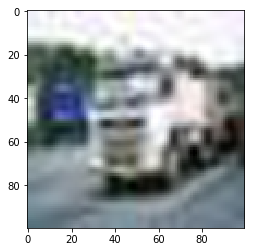

In [155]:
# Display an image
plt.imshow(X[9].astype(np.uint8))

In [49]:
# Print some Y's and J's. J = 0 means left hand, J = 1 means right hand.
# Y = 1 means hand is present in the image.
print(Y[:10])
print(Hand_Info[:10])

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]


In [50]:
labels = gen_labels(Y, Joints)

min_x 0.5296875
max_x 0.594791666667
min_y 0.365740740741
max_y 0.487962962963
height 0.122222222222
width 0.0651041666667
center_x 0.562239583333
center_y 0.426851851852
min_x 0.531591666667
max_x 0.587254166667
min_y 0.369251851852
max_y 0.489444444444
height 0.120192592593
width 0.0556625
center_x 0.559422916667
center_y 0.429348148148
min_x 0.574730208333
max_x 0.589764583333
min_y 0.368792592593
max_y 0.493603703704
height 0.124811111111
width 0.015034375
center_x 0.582247395833
center_y 0.431198148148
min_x 0.535788541667
max_x 0.584159375
min_y 0.395161111111
max_y 0.489387037037
height 0.0942259259259
width 0.0483708333333
center_x 0.559973958333
center_y 0.442274074074
min_x 0.547366666667
max_x 0.582615625
min_y 0.416648148148
max_y 0.489375925926
height 0.0727277777778
width 0.0352489583333
center_x 0.564991145833
center_y 0.453012037037
min_x 0.547752083333
max_x 0.577623958333
min_y 0.429487037037
max_y 0.493125925926
height 0.0636388888889
width 0.029871875
center_x 0.562

In [90]:
labels[7]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.56239896,  0.70303148,  0.08239259,  0.0425625 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]])

In [95]:
np.argwhere(labels[7] == 1)

array([[2, 1, 0]])

In [62]:
_, cx, cy, h, w = labels[7][2][1]

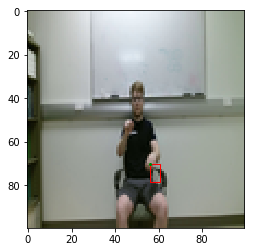

In [88]:
fig, ax = plt.subplots()
plt.imshow(X[7].astype(np.uint8))
plt.plot(cx*100, cy*100, color='g', marker='o', markersize='2')
r = plt.Rectangle(((cx)*100, (cy)*100), w*100, h*100, edgecolor='r', facecolor='none')
ax.add_artist(r)
plt.show()

In [167]:
X[9].shape

(100, 100, 3)

In [178]:
X_rolled = np.rollaxis(X, axis=3)
X_rolled = np.rollaxis(X_rolled, axis=1)
X_rolled.shape

(10, 3, 100, 100)

In [182]:
X[0][10,15,:]

array([ 185.,  189.,  184.])

In [183]:
X_rolled[0][:,10,15]

array([ 185.,  189.,  184.])

# PyTorch

In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit

In [184]:
def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(X_rolled):
            x_var = Variable(x.type(dtype))
            y_var = Variable(y.type(dtype))

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [185]:
dtype = torch.FloatTensor # the CPU datatype

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [188]:
fixed_model_base = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(16, 16, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(16, 16, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(16, 16, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(16, 5, kernel_size=2, stride=1),
        nn.ReLU(inplace=True),
    )

fixed_model = fixed_model_base.type(dtype)

loss_fn = nn.MSELoss().type(dtype)
optimizer = optim.RMSprop(fixed_model.parameters(), lr=1e-2)


## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
# x = torch.randn(64, 3, 100, 100).type(dtype)
# x_var = Variable(x.type(dtype)) # Construct a PyTorch Variable out of your input data

X_tensor = torch.from_numpy(X_rolled)
x_var = Variable(X_tensor.type(dtype))
ans = fixed_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
# np.array_equal(np.array(ans.size()), np.array([64, 10]))    